In [1]:
import json
import urllib 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime 

In [2]:
params = {}
url='https://aqs.epa.gov/data/api/list/parametersByClass?email=samavedamanjali@gmail.com&key=russetcrane95&pc=CRITERIA'
with urllib.request.urlopen(url) as urlhandle:
    params = json.loads(urlhandle.read().decode())

params_dict = {}
for i in params['Data']:
    #print (i['code'], i['value_represented'])
    params_dict[i['code']] = i['value_represented']
del params_dict['14129']  # Some issue with data for this; ignore for now
del params_dict['81102']
del params_dict['85129']
print (params_dict)

{'42101': 'Carbon monoxide', '42401': 'Sulfur dioxide', '42602': 'Nitrogen dioxide (NO2)', '44201': 'Ozone', '88101': 'PM2.5 - Local Conditions'}


In [4]:
params_dict = {'42101': 'CarbonMonoxide', '42401': 'SulfurDioxide', '42602': 'NitrogenDioxide', '44201': 'Ozone', '88101': 'PM2.5LocalConditions'}

In [101]:
def readAndDisplayFile(c,p,y):
    f_name = '../Anjali/data/'+c+'_'+p+'_'+y+'.json'
    with open(f_name) as json_file:
        data = json.load(json_file)
        #print(data)
        df = pd.DataFrame.from_dict(data['Data'])

        if (df.size != 0) :
            # get only the needed cols out of 30+ columns
            df = df[['date_local','arithmetic_mean']]
            # agggregate by date so that we have one value per day
            df = df.groupby('date_local').mean().reset_index()
        return df;

In [102]:
def readAndDisplayFileYearRange(c,px,ya,yb):
    #print(c,px,ya,yb)
    df_ab = pd.DataFrame()
    for y in range(ya,yb):
        df1 = readAndDisplayFile('Baltimore',px,str(y));
        df_ab = df_ab.append(df1)
    return df_ab
    
#df = readAndDisplayFile('Baltimore','p','2011');

In [103]:
p='42101'
df_10_14 = readAndDisplayFileYearRange('Baltimore',p,2010,2020)

42101 CarbonMonoxide
42401 SulfurDioxide
42602 NitrogenDioxide
44201 Ozone
88101 PM2.5LocalConditions


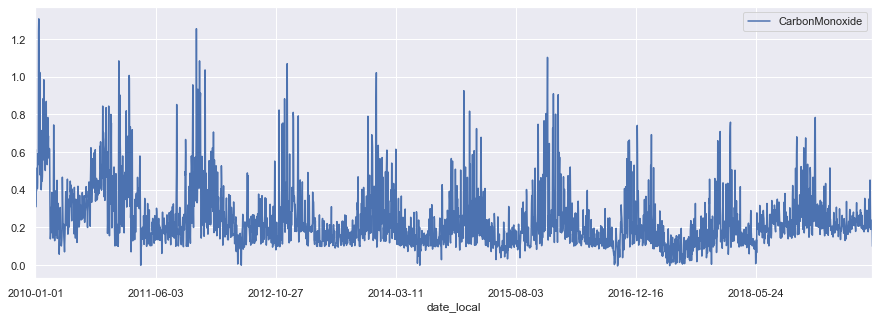

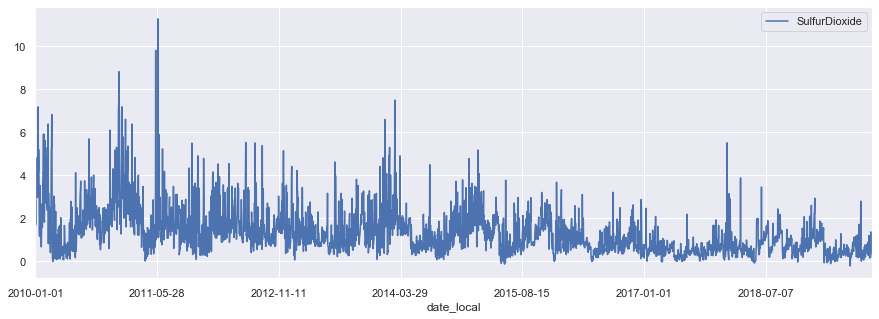

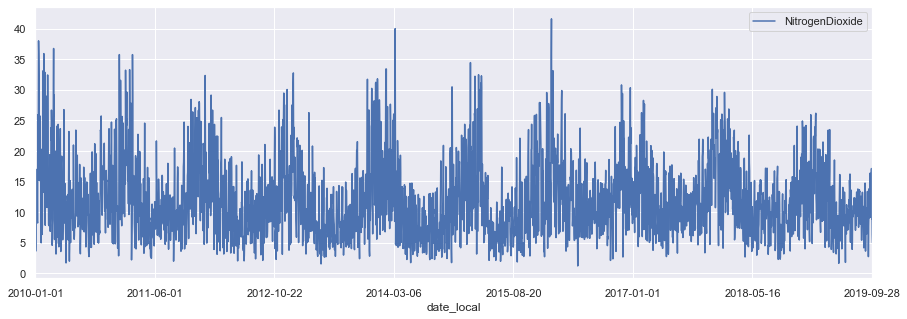

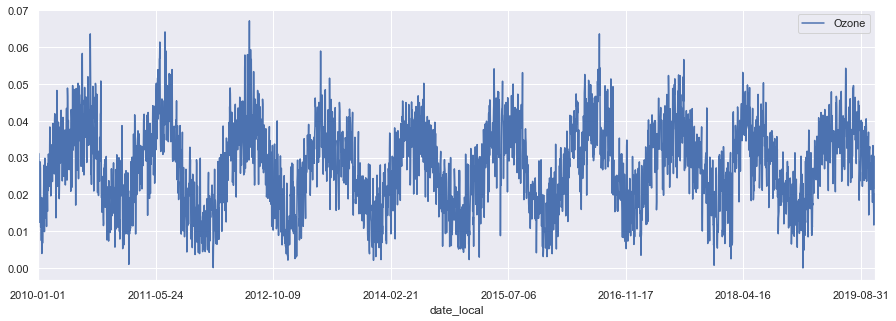

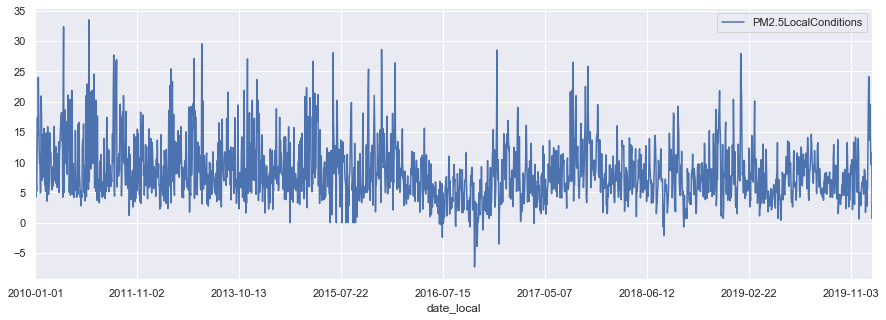

In [104]:

for p in params_dict.keys():
    print(p, params_dict[p])

    df = readAndDisplayFileYearRange('Baltimore',p,2010,2020)    
    df.columns = ['date_local', params_dict[p]]
    df.groupby('date_local').mean().plot(figsize=(15,5))



In [19]:
#df.columns = ['date_local', params_dict['42602']]
#df.groupby('date_local').mean().plot(figsize=(15,5))

In [20]:
#df.info()

In [21]:
#df['date_local'].value_counts()

In [12]:
def dayofyear():
    x = datetime.date(2019, 4, 13)
    y = datetime.date(2019,4,14)
    one_day = y-x
    num_days = datetime.date(2011, 12, 31) - datetime.date(2010, 1, 1)
    begin = datetime.date(2010, 1, 1)
    end = datetime.date(2011, 12, 31)
    for d in range(0, num_days.days):
        newDate = (str(begin + (d*one_day)))
        print(newDate)
    return newDate

#dayofyear()

In [110]:
df_master = {}

for p in params_dict.keys():
    print(p, params_dict[p])
    df = readAndDisplayFileYearRange('Baltimore',p,2010,2020)    
    #df.columns = ['date_local', params_dict[p]]
    df_master[p] = df;   


42101 CarbonMonoxide
42401 SulfurDioxide
42602 NitrogenDioxide
44201 Ozone
88101 PM2.5LocalConditions


In [116]:
def combineParamCols(ya,yb):
    x = datetime.date(2019, 1, 1)
    y = datetime.date(2019,1,2)
    one_day = y-x

    begin = datetime.date(ya, 1, 1)
    end = datetime.date(yb, 12, 31)
    num_days = end - begin
    print(begin, end)
    data_master = {}
    data_master['date_local'] = []
    for p in params_dict.keys():
        data_master[p] = []

    df_new = pd.DataFrame(data_master)            

    for d in range(0, num_days.days):
        new_date = str(begin + (d*one_day))
        data_master['date_local'].append(new_date)
        for p in params_dict.keys():
            df = df_master[p]
            try:
                val = df[df.date_local==new_date]['arithmetic_mean'].values[0]
                #print(new_date,p, val)
                data_master[p].append(val)
                #print (data_master[p])
            except:
                data_master[p].append(0) #### TBD to think about missing data later 

    return pd.DataFrame(data_master)           


In [126]:
y=2011
df_comb = combineParamCols(y,y)
corrmat = df_comb.corr()
yrly_corrs = {}    
for y in range(2010, 2020):
    df_comb = combineParamCols(y,y)
    yrly_corrs[y] = df_comb.corr()
    


2011-01-01 2011-12-31
2010-01-01 2010-12-31
2011-01-01 2011-12-31
2012-01-01 2012-12-31
2013-01-01 2013-12-31
2014-01-01 2014-12-31
2015-01-01 2015-12-31
2016-01-01 2016-12-31
2017-01-01 2017-12-31
2018-01-01 2018-12-31
2019-01-01 2019-12-31


In [134]:
for pa in params_dict.keys():
    for pb in params_dict.keys():
        for y in range(2010, 2020):
            print(pa,yrly_corrs[y][pa][pb])
        print ('-----------------------------')

42101 1.0
42101 1.0
42101 1.0
42101 1.0
42101 1.0
42101 1.0
42101 1.0
42101 1.0
42101 1.0
42101 1.0
-----------------------------
42101 0.5257643838690018
42101 0.38911336251532974
42101 0.39391875807875626
42101 0.4320359192808762
42101 0.465228302381251
42101 0.4893900722159602
42101 0.6432244873565118
42101 0.5586128858135523
42101 0.3766213686658853
42101 0.7165804420536618
-----------------------------
42101 0.6479635379779429
42101 0.7677175510645835
42101 0.8243170263894035
42101 0.8625410332870226
42101 0.8297762190756645
42101 0.7274277448019775
42101 0.7778709237300749
42101 0.6440747574290926
42101 0.4958436391883071
42101 0.8804652782300293
-----------------------------
42101 -0.39137182362982464
42101 -0.475090407886278
42101 -0.3933561250458183
42101 -0.543649752132308
42101 -0.5566945120413067
42101 -0.5332295929010333
42101 -0.4574696165330571
42101 -0.4280626939778683
42101 -0.27520754971980055
42101 0.48267642525686927
-----------------------------
42101 0.07298318510

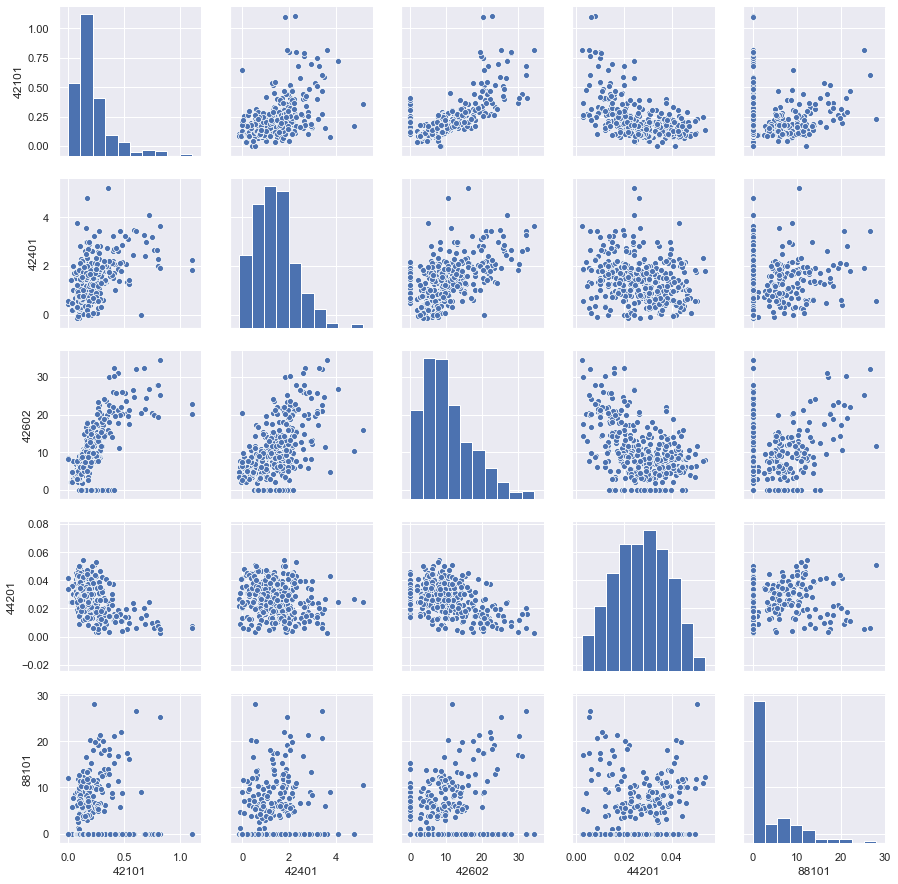

In [114]:
df_comb = combineParamCols(2015,2015)
sns.set()
cols = params_dict.keys()
sns.pairplot(df_comb[cols], height=2.5)
plt.show()

          42101     42401     42602     44201     88101
42101  1.000000  0.466771  0.722017 -0.379923  0.135619
42401  0.466771  1.000000  0.488965 -0.049806  0.153187
42602  0.722017  0.488965  1.000000 -0.425448  0.142738
44201 -0.379923 -0.049806 -0.425448  1.000000  0.077273
88101  0.135619  0.153187  0.142738  0.077273  1.000000
          42101     42401     42602     44201     88101
42101  1.000000  0.466771  0.722017 -0.379923  0.135619
42401  0.466771  1.000000  0.488965 -0.049806  0.153187
42602  0.722017  0.488965  1.000000 -0.425448  0.142738
44201 -0.379923 -0.049806 -0.425448  1.000000  0.077273
88101  0.135619  0.153187  0.142738  0.077273  1.000000
          42101     42401     42602     44201     88101
42101  1.000000  0.466771  0.722017 -0.379923  0.135619
42401  0.466771  1.000000  0.488965 -0.049806  0.153187
42602  0.722017  0.488965  1.000000 -0.425448  0.142738
44201 -0.379923 -0.049806 -0.425448  1.000000  0.077273
88101  0.135619  0.153187  0.142738  0.077273  1

In [168]:
corrmat

,42101,42401,42602,44201,88101
42101,1.000000,0.389113,0.767718,-0.475090,0.131997
42401,0.389113,1.000000,0.469317,0.009882,0.145622
42602,0.767718,0.469317,1.000000,-0.484023,0.135425
44201,-0.475090,0.009882,-0.484023,1.000000,0.115413
88101,0.131997,0.145622,0.135425,0.115413,1.000000
